## Binary Classification with XGBoost

In [95]:
# load packages
import os
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import TimeSeriesSplit
from imblearn.over_sampling import SMOTE

from xgboost import XGBClassifier

from sklearn.metrics import confusion_matrix, precision_score, f1_score
from matplotlib import pyplot as plt

from sklearn.model_selection import GridSearchCV

In [96]:
# mount your google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [110]:
# load lagged dataset
df = pd.read_csv('/content/drive/My Drive/ms_wind_curtailment_prediction/lagged_curtailment_target_features.csv', sep = ';', index_col=0)

In [111]:
# get desired df size
start_date = '2021-01-01'
end_date = '2023-06-30'
df = df.loc[start_date:end_date]

In [112]:
# impute, scale pipeline and smote (for class imbalance)
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('scaler', StandardScaler())
])

smote = SMOTE(random_state=13)

# define features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [113]:
# importance of the last redispatch status for the training data
def last_redispatch(y_train, window_size=2): #2h in advance
    """
    Computes the importance of the last redispatch status for each data point in the training data
    using a rolling window. It creates a list by summing the redispatch statuses of the
    last values within the defined window. (LAST SENTENCE TO BE CHANGED)
    """
    last_redispatch_importance = []
    for i in range(len(y_train)):
        window_start = max(0, i - window_size)
        window_end = i
        importance = y_train.iloc[window_start:window_end].sum()/window_size
        last_redispatch_importance.append(importance)

    return last_redispatch_importance

**XGBoost**\
tbd.

**K-fold cross-validation**\
tbd.

Average Scores:
Precision: 0.5296133175390141
F1-Scores: 0.6572228896823203
Confusion Matrix: [[24.66666667  9.5       ]
 [ 0.66666667 13.16666667]]
Precision (Train): 0.8013169666233786
F1-Scores (Train): 0.5550388408342407
Confusion Matrix (Train): [[70663.83333333  8313.66666667]
 [45444.5        33533.        ]]


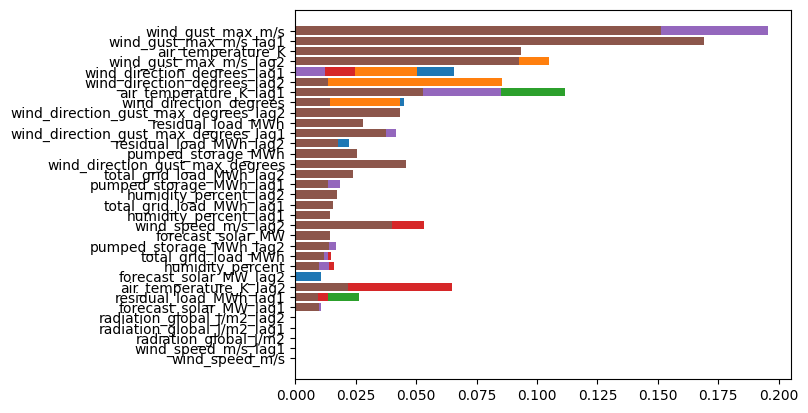

In [123]:
# create model instance
xgboost_class = XGBClassifier(booster='gbtree', reg_alpha=5, reg_lambda=5, eval_metric='logloss',
                              n_estimators=200, max_depth=1, learning_rate=0.1, objective='binary:logistic', random_state = 13)
# reg_alpha: L1 regularization (reduce overfitting)
# gamma: minimum loss reduction required to make a further partition on a leaf node of the tree (larger gamma more conservative (reduce overfitting))
# scale_pos_weights: higher weight to the minority class to address class imbalance

# cross-validation
n_splits = 70
test_size = 48 #(48 - 12h with 15 min intervalls)
tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size, gap = 10)

precision_scores = []
f1_scores = []
conf_matrices = []
precision_train_scores = []
f1_train_scores = []
conf_train_matrices = []

for train_index, test_index in tscv.split(X):

    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    X_train = X_train.copy()
    X_test = X_test.copy()

    # having at least one instance of redispatch 1 or 0 in test
    if y_test.sum() == 0 or y_test.sum() == 1:
        continue

    # preprocess train data
    X_train_scaled = preprocessor.fit_transform(X_train)
    X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)

    '''
    # add importance of the last redispatch status for train
    last_redispatch_importance_train = last_redispatch(y_train_preprocessed)
    X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
    X_train_preprocessed['last_redispatch_importance'] = last_redispatch_importance_train
    '''

    # fit model
    xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)

    # add importance of the last redispatch status for test and predict
    X_test_preprocessed = preprocessor.transform(X_test)

    # with threshold for prediction
    threshold = 0.65
    y_pred_proba = xgboost_class.predict_proba(X_test_preprocessed)[:, 1]
    y_pred = (y_pred_proba >= threshold).astype(int)
    y_train_proba = xgboost_class.predict_proba(X_train_preprocessed)[:, 1]
    y_pred_train = (y_train_proba >= threshold).astype(int)

    '''
    X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed, columns=X_test.columns)
    X_test_preprocessed_df['last_redispatch_importance'] = 0
    y_pred = np.zeros(len(X_test))

    window = 2
    for i in range(len(X_test)):
        if i == 0:
            last_redispatch_importance = y_train.iloc[-2:].sum() / window
        elif i == 1:
            last_redispatch_importance = (y_train.iloc[-1:].sum() + y_pred[i - 1]) / window
        else:
            last_redispatch_importance = (y_pred[i - 2] + y_pred[i - 1]) / window
        X_test_preprocessed_df.loc[i, 'last_redispatch_importance'] = last_redispatch_importance
        y_pred[i] = xgboost_class.predict(X_test_preprocessed_df.iloc[[i]].values.reshape(1, -1))[0]
    '''

    # evaluate
    precision_scores.append(precision_score(y_test, y_pred))
    f1_scores.append(f1_score(y_test, y_pred))
    conf_matrices.append(confusion_matrix(y_test, y_pred))

    precision_train_scores.append(precision_score(y_train_preprocessed, y_pred_train))
    f1_train_scores.append(f1_score(y_train_preprocessed, y_pred_train))
    conf_train_matrices.append(confusion_matrix(y_train_preprocessed, y_pred_train))

    sorted_idx = xgboost_class.feature_importances_.argsort()
    plt.barh(X_test.columns[sorted_idx], xgboost_class.feature_importances_[sorted_idx])

# print evaluation results
print("Average Scores:")
print("Precision:", sum(precision_scores) / len(precision_scores))
print("F1-Scores:", sum(f1_scores) / len(f1_scores))
print("Confusion Matrix:", sum(conf_matrices) / len(conf_matrices))
print("Precision (Train):", sum(precision_train_scores) / len(precision_train_scores))
print("F1-Scores (Train):", sum(f1_train_scores) / len(f1_train_scores))
print("Confusion Matrix (Train):", sum(conf_train_matrices) / len(conf_train_matrices))

In [ ]:
'''
Average Scores:
Precision: 0.5296133175390141
F1-Scores: 0.6572228896823203
Confusion Matrix: [[24.66666667  9.5       ]
 [ 0.66666667 13.16666667]]
Precision (Train): 0.8013169666233786
F1-Scores (Train): 0.5550388408342407
Confusion Matrix (Train): [[70663.83333333  8313.66666667]
 [45444.5        33533.        ]]
'''

In [ ]:
# train model on larger train data set and save

# get desired df size
start_date = '2021-01-01'
end_date = '2023-06-30'
df = df.loc[start_date:end_date]

# define features X and target y
X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

# preprocess train data
X_train_scaled = preprocessor.fit_transform(X_train)
X_train_preprocessed, y_train_preprocessed = smote.fit_resample(X_train_scaled, y_train)

# add importance of the last redispatch status for train
last_redispatch_importance_train = last_redispatch(y_train_preprocessed)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed, columns=X_train.columns)
X_train_preprocessed['last_redispatch_importance'] = last_redispatch_importance_train

# fit model
xgboost_class.fit(X_train_preprocessed, y_train_preprocessed)



**Grid Search CV**

• it is doing its own train/test split\
• the last feature importance is calculated for every timestamp. to not get wrong results it is shifted by 48 (12h)


In [ ]:
# importance of the last redispatch status for the training data
window_size = 4  #last 60 min
last_redispatch_importance = []
for i in range(len(df)):
    window_start = max(0, i - window_size)
    window_end = i
    importance = df['redispatch'].iloc[window_start:window_end].sum() #also incorporate the level ???
    last_redispatch_importance.append(importance)

df['last_redispatch_importance'] = last_redispatch_importance
df['last_redispatch_importance'] = df['last_redispatch_importance'].shift(48)
df.dropna(inplace = True)

X = df.drop(['redispatch', 'level'], axis = 1)
y = df['redispatch']

In [ ]:
# preprocess data
X_scaled = preprocessor.fit_transform(X)
X_preprocessed, y_preprocessed = smote.fit_resample(X_scaled, y)

# parameter grid
param_grid = {
    'n_estimators': [200, 250, 300],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.1, 0.01, 0.001],
    'gamma': [0, 1, 5],
    'reg_alpha': [0, 0.1, 0.5]
}

# timeseries split
test_size = 48
tscv = TimeSeriesSplit(test_size=test_size)

# XGBClassifier and GridSearchCV
xgboost_class = XGBClassifier(booster='gbtree', eval_metric='logloss', objective='binary:logistic', random_state=13)
grid_search = GridSearchCV(estimator=xgboost_class, param_grid=param_grid, cv=tscv, scoring='precision', n_jobs=-1)

# fit
grid_search.fit(X_scaled, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

KeyboardInterrupt: 

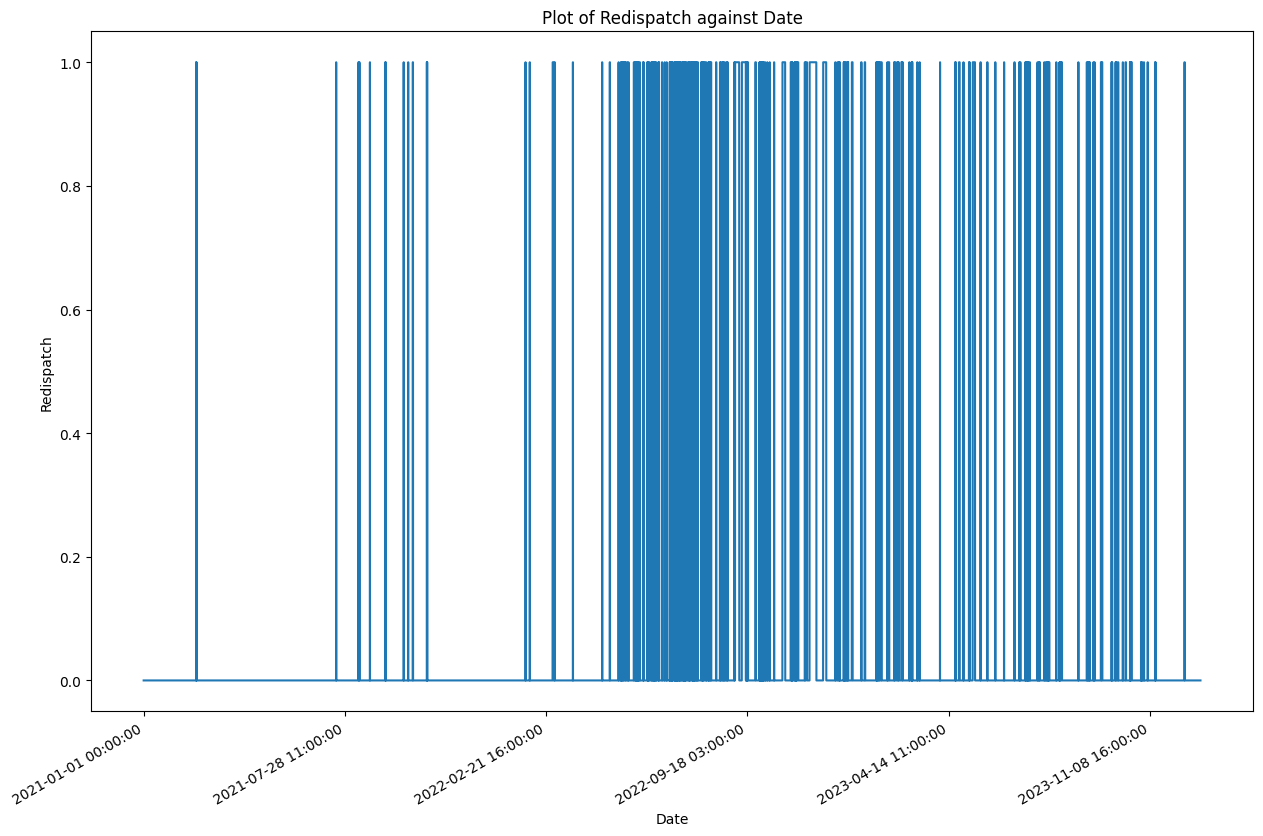

In [ ]:
# plot redispatch against the datetime index
start_date = '2021-01-01'
end_date = '2023-12-31'

ax = df.loc[start_date:end_date, 'redispatch'].plot(figsize=(15, 10))

# Customize the x-axis format and limits
plt.gcf().autofmt_xdate()

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Redispatch')
plt.title('Plot of Redispatch against Date')

# Show the plot
plt.show()